# Modeling with StatsModels

## 1. Ordinary Least Square
- Column Names
- Log Transformation
- Condition Number
- Standard Scaling

# 2. Dimensionality Reduction
- ANOVA
- F-test and Feature Influence

# 3. Outlier
- Cook's Distance

# 4. Regularization
- Lasso

# 5. Diagnosis of Regression
- Residual Normality Test
- Partial Regression Plot

# 6. Cross Validatoin

# 7. Test
- score

In [1]:
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import warnings
import sys
import os
import datetime
import scipy as sp
import statsmodels.stats.api as sms
import statsmodels.api as sm
from patsy import dmatrix
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('github'))))
import utils.statsmodel_helper as sh
import utils.feature_selection as fs
import utils.preprocessing as pp
import utils.error_calculator as ec

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

df_train_macro = pd.read_csv('../input/train_macro.csv', index_col=0)
df_test_macro = pd.read_csv('../input/test_macro.csv', index_col=0)

sys.setrecursionlimit(1500)

degree = 2
skewness_limit = 1
num_of_cooks = 2
num_of_f_test = 10

In [2]:
df_train_macro.tail(2)

,usdrub,full_sq,life_sq,floor,num_room,kitch_sq,state,product_type,area_m,preschool_education_centers_raion,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,0_17_all,raion_build_count_with_material_info,build_count_brick,build_count_monolith,raion_build_count_with_builddate_info,build_count_before_1920,metro_min_avto,kindergarten_km,school_km,park_km,railroad_station_walk_min,railroad_station_avto_min,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,leisure_count_1000,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_max_price_avg,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,mosque_count_2000,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,room_size,avg_price_ID_metro,avg_price_ID_railroad_station_walk,avg_price_ID_big_road1,avg_price_ID_big_road2,avg_price_ID_railroad_terminal,avg_price_ID_bus_terminal,avg_price_sub_area,price_doc
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30472,55.2655,64,32.0,5.0,2.0,11.0,2.0,Investment,6050064.566,6,8,0,3300.0,2,1,11,no,4,5,no,no,no,yes,no,no,no,no,10896,185.0,4.0,9.0,186.0,0.0,3.377814,0.203020,0.130667,1.772506,82.750340,9.128624,3.138330,no,8.940313,11.752036,12.872535,13.622569,0.960608,no,2.174001,no,15.303338,5.458660,19.591574,8.011139,0.718679,1.971656,6.417997,3.781523,2.711199,0.412813,0.631280,2.630674,2.374106,2.210500,1.625064,24.788893,2.328096,1.982450,2.340429,1.108672,1.204798,1.340017,0.130667,1.644053,0.476021,2.748055,2.088193,4.119706,1.800186,0.134566,satisfactory,0,0,3,0,3,0,0,0,13,0,6,5,0,0,10,1,37800,1,42,646.34,1097.56,871.95,1,15,13,8,5,0,0,0,15,32.00,2,107800,10,136296,67,1195.31,3,17,23,15,9,0,0,18,2,30.31,15,473168,25,481350,2,17,2,33,4,30.36,39,1225712,45,1464521,6,31,1,4,65,7,16.0,8.917337e+06,1.038111e+07,1.176580e+07,1.127070e+07,7.042021e+06,6.331645e+06,1.392420e+07,13500000
30473,55.2655,43,28.0,1.0,2.0

In [3]:
df_train_macro.columns

Index(['usdrub', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq',
       'state', 'product_type', 'area_m', 'preschool_education_centers_raion',
       ...
       'market_count_5000', 'room_size', 'avg_price_ID_metro',
       'avg_price_ID_railroad_station_walk', 'avg_price_ID_big_road1',
       'avg_price_ID_big_road2', 'avg_price_ID_railroad_terminal',
       'avg_price_ID_bus_terminal', 'avg_price_sub_area', 'price_doc'],
      dtype='object', length=157)

# 1. Column Names
## Column Names
Replace -, +, :, ~, * in column name with underscore

In [4]:
new_cols = []
for col in  list(df_train_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_train_macro.columns = new_cols

new_cols = []
for col in list(df_test_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_test_macro.columns = new_cols

categorial_ivs = list(set(df_train_macro.columns) - set(df_train_macro._get_numeric_data().columns))
numeric_ivs = df_train_macro._get_numeric_data().columns.drop('_price_doc').tolist()

## Log Transformation
Transform data with skewness greater than 1.

In [5]:
features_to_log = []
for f in df_train_macro._get_numeric_data().columns:
    skewness = sp.stats.skew(df_train_macro[f])
    if skewness > skewness_limit:
        features_to_log.append(f)

for col in df_train_macro._get_numeric_data().columns:
    if col != '_price_doc':
        min_val_train = min(df_train_macro[col])
        min_val_test  = min(df_test_macro[col])
        min_val = min(min_val_train, min_val_test)
        if min_val <= 0:
            df_train_macro[col] += (np.abs(min_val) + 0.1)
            df_test_macro[col]  += (np.abs(min_val) + 0.1)
    else:
        min_val_train = min(df_train_macro[col])
        if min_val_train <= 0:
            df_train_macro[col] += (np.abs(min_val_train) + 0.1)

In [6]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=False)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     580.7
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:21:42   Log-Likelihood:                -19237.
No. Observations:               30404   AIC:                         3.855e+04
Df Residuals:                   30365   BIC:                         3.888e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  0.0061      0.001      6.347      0.000       0.004       0.008
C(_big_market_raion)[T.yes]                                0.0322      0.018      1.752      0.080      -0.004       0.068
C(_radiation_raion)[T.yes]                                -0.0280      0.013     -2.101      0.036      -0.054      -0.002
C(_railroad_terminal_raion)[T.yes]                         0.0380      0.016      2.395      0.017       0.007       0.069
C(_incineration_raion)[T.yes]                             -0.0354      0.015     -2.407      0.016      -0.064      -0.007
C(_detention_facility_raion)[T.yes]                        0.0088      0.018      0.487      0.626      -0.027       0.044
C(_ecology)[T.good]                                       -0.0097      0.014     -0.674      0.500      -0.038       0.018
C(_ecology)[T.no data]                                     0.0272      0.010      2.817      0.005       0.008       0.046
C(_ecology)[T.poor]                                        0.0006      0.013      0.049      0.961      -0.025       0.026
C(_ecology)[T.satisfactory]                               -0.0273      0.014     -1.880      0.060      -0.056       0.001
C(_product_type)[T.OwnerOccupier]                          0.1476      0.013     11.403      0.000       0.122       0.173
C(_thermal_power_plant_raion)[T.yes]                      -0.0243      0.019     -1.307      0.191      -0.061       0.012
C(_culture_objects_top_25)[T.yes]                         -0.0099      0.020     -0.505      0.614      -0.049       0.029
C(_oil_chemistry_raion)[T.yes]                            -0.0072      0.008     -0.860      0.390      -0.024       0.009
C(_water_1line)[T.yes]                                     0.0029      0.013      0.222      0.824      -0.023       0.029
C(_big_road1_1line)[T.yes]                                -0.0404      0.019     -2.109      0.035      -0.078      -0.003
C(_railroad_1line)[T.yes]                                 -0.0663      0.020     -3.282      0.001      -0.106      -0.027
C(_nuclear_reactor_raion)[T.yes]                          -0.0095      0.017     -0.565      0.572      -0.042       0.023
np.log(_usdrub)                                            0.0122      0.001     13.290      0.000       0.010       0.014
np.log(_full_sq)                                           0.0074      0.004      1.745      0.081      -0.001       0.016
np.log(_life_sq)                                           0.0131      0.008      1.727      0.084      -0.002       0.028
_floor                                                     0.0081      0.002      5.138      0.000       0.005       0.011
np.log(_

## Condition Number
Large condition number occurs when the scale of data changes significantly due to the unit difference. Scaling can decrease condition number. Multicollinearity can also cause large condition number. We can handle this by reducing dimensionality with variance inflation factor.

## Standard Scaling
Standalize variables by removing the mean and scaling to unit variance.

In [7]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=True)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     75.22
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:23:08   Log-Likelihood:                -19058.
No. Observations:               30404   AIC:                         3.872e+04
Df Residuals:                   30104   BIC:                         4.121e+04
Df Model:                         299                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.5804      0.027    585.322      0.000      15.528      15.633
C(_big_market_raion)[T.yes]                                       0.0642      0.026      2.457      0.014       0.013       0.115
C(_radiation_raion)[T.yes]                                       -0.0444      0.014     -3.283      0.001      -0.071      -0.018
C(_railroad_terminal_raion)[T.yes]                                0.0719      0.036      1.980      0.048       0.001       0.143
C(_incineration_raion)[T.yes]                                     0.0734      0.038      1.918      0.055      -0.002       0.148
C(_detention_facility_raion)[T.yes]                               0.0109      0.021      0.517      0.605      -0.030       0.052
C(_ecology)[T.good]                                              -0.0371      0.028     -1.315      0.188      -0.092       0.018
C(_ecology)[T.no data]                                            0.0186      0.059      0.316      0.752      -0.097       0.134
C(_ecology)[T.poor]                                              -0.0335      0.020     -1.668      0.095      -0.073       0.006
C(_ecology)[T.satisfactory]                                      -0.0506      0.028     -1.830      0.067      -0.105       0.004
C(_product_type)[T.OwnerOccupier]                                 0.1518      0.013     11.754      0.000       0.127       0.177
C(_thermal_power_plant_raion)[T.yes]                             -0.0567      0.026     -2.203      0.028      -0.107      -0.006
C(_culture_objects_top_25)[T.yes]                                 0.0167      0.027      0.616      0.538      -0.037       0.070
C(_oil_chemistry_raion)[T.yes]                                   -0.0152      0.051     -0.301      0.764      -0.114       0.084
C(_water_1line)[T.yes]                                        -9.426e-05      0.013     -0.007      0.994      -0.026       0.025
C(_big_road1_1line)[T.yes]                                       -0.0375      0.020     -1.856      0.063      -0.077       0.002
C(_railroad_1line)[T.yes]                                        -0.0691      0.020     -3.431      0.001      -0.109      -0.030
C(_nuclear_reactor_raion)[T.yes]                                  0.0498      0.034      1.473      0.141      -0.016       0.116
scale(np.log(_usdrub))                                            0.9363      0.107      8.746      0.000       0.727       1.146
scale(np.log(_full_sq))                                           0.0448      0.045      1.005      0.315      -0.043       0.132
scale(np.log(_life_sq))                                           0.0318      0.018      1.78

Scaling did not significantly decrease the condition number.

# 2. Dimensionality Reduction
## ANOVA

In [8]:
anova = sm.stats.anova_lm(result, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(_big_market_raion),1.250392e+00,1.0,6.036136,1.402153e-02
C(_radiation_raion),2.232052e+00,1.0,10.774995,1.029977e-03
C(_railroad_terminal_raion),8.121267e-01,1.0,3.920456,4.771104e-02
C(_incineration_raion),7.619809e-01,1.0,3.678382,5.513176e-02
C(_detention_facility_raion),5.543860e-02,1.0,0.267624,6.049339e-01
C(_ecology),1.053540e+00,4.0,1.271464,2.786273e-01
C(_product_type),2.861934e+01,1.0,138.156851,7.905109e-32
C(_thermal_power_plant_raion),1.005554e+00,1.0,4.854203,2.758639e-02
C(_culture_objects_top_25),7.850842e-02,1.0,0.378991,5.381483e-01
C(_oil_chemistry_raion),1.872743e-02,1.0,0.090405,7.636654e-01



We can remove features with p-value equal or greater than 0.05 since they have very small influences on the dependent variable

## F-test and Feature Influence

In [9]:
result, sms_vars, formula = fs.by_f_test(df_train_macro, formula, repeat=num_of_f_test)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     305.4
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:27:41   Log-Likelihood:                -19431.
No. Observations:               30404   AIC:                         3.900e+04
Df Residuals:                   30333   BIC:                         3.960e+04
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.5653      0.005   2857.726      0.000      15.555      15.576
C(_big_market_raion)[T.yes]                                       0.0293      0.014      2.048      0.041       0.001       0.057
C(_radiation_raion)[T.yes]                                       -0.0224      0.007     -3.000      0.003      -0.037      -0.008
C(_product_type)[T.OwnerOccupier]                                 0.1523      0.010     15.202      0.000       0.133       0.172
C(_railroad_1line)[T.yes]                                        -0.1028      0.018     -5.780      0.000      -0.138      -0.068
scale(np.log(_usdrub))                                            0.9658      0.105      9.206      0.000       0.760       1.171
scale(_floor)                                                     0.0439      0.008      5.407      0.000       0.028       0.060
scale(_state)                                                    -0.1082      0.016     -6.738      0.000      -0.140      -0.077
scale(np.log(_university_top_20_raion))                           0.0801      0.020      3.920      0.000       0.040       0.120
scale(np.log(_raion_build_count_with_material_info))            -25.7767      3.411     -7.558      0.000     -32.462     -19.092
scale(np.log(_raion_build_count_with_builddate_info))            25.8290      3.418      7.557      0.000      19.130      32.528
scale(np.log(_build_count_before_1920))                          -0.0162      0.005     -2.992      0.003      -0.027      -0.006
scale(np.log(_school_km))                                         0.0515      0.017      2.962      0.003       0.017       0.086
scale(np.log(_railroad_station_walk_min))                         0.0735      0.019      3.792      0.000       0.036       0.111
scale(np.log(_public_transport_station_min_walk))                -0.0159      0.004     -3.722      0.000      -0.024      -0.008
scale(np.log(_kremlin_km))                                        0.1802      0.012     14.616      0.000       0.156       0.204
scale(_big_road1_km)                                              0.0326      0.011      3.022      0.003       0.011       0.054
scale(np.log(_zd_vokzaly_avto_km))                                0.0729      0.016      4.639      0.000       0.042       0.104
scale(np.log(_power_transmission_line_km))                        0.0113      0.005      2.423      0.015       0.002       0.020
scale(np.log(_market_shop_km))                                   -0.0080      0.004     -2.000      0.045      -0.016      -0.000
scale(np.log(_additional_education_km))                          -0.0239      0.004     -5.71

# 3. Outlier
## Cook's Distance
- Find data with large leverage and residual by calculating Cook's distance.

In [10]:
df_train_macro_with_outliers = df_train_macro.copy(deep=True)
df_train_macro, model, result = pp.remove_outliers(df_train_macro, formula, repeat=3)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     3202.
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:28:36   Log-Likelihood:                 15089.
No. Observations:               26801   AIC:                        -3.004e+04
Df Residuals:                   26730   BIC:                        -2.945e+04
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.7534      0.002   8486.604      0.000      15.750      15.757
C(_big_market_raion)[T.yes]                                      -0.0040      0.005     -0.859      0.390      -0.013       0.005
C(_radiation_raion)[T.yes]                                       -0.0090      0.002     -3.652      0.000      -0.014      -0.004
C(_product_type)[T.OwnerOccupier]                                -0.0549      0.003    -16.723      0.000      -0.061      -0.048
C(_railroad_1line)[T.yes]                                        -0.1117      0.006    -18.698      0.000      -0.123      -0.100
scale(np.log(_usdrub))                                            0.6476      0.034     19.160      0.000       0.581       0.714
scale(_floor)                                                     0.0579      0.003     21.241      0.000       0.053       0.063
scale(_state)                                                    -0.0912      0.005    -17.670      0.000      -0.101      -0.081
scale(np.log(_university_top_20_raion))                          -0.0014      0.007     -0.195      0.846      -0.016       0.013
scale(np.log(_raion_build_count_with_material_info))            -13.9459      1.138    -12.252      0.000     -16.177     -11.715
scale(np.log(_raion_build_count_with_builddate_info))            13.9667      1.141     12.243      0.000      11.731      16.203
scale(np.log(_build_count_before_1920))                          -0.0170      0.002     -9.765      0.000      -0.020      -0.014
scale(np.log(_school_km))                                         0.0187      0.006      3.089      0.002       0.007       0.031
scale(np.log(_railroad_station_walk_min))                         0.0360      0.006      5.636      0.000       0.024       0.049
scale(np.log(_public_transport_station_min_walk))                -0.0134      0.001     -9.488      0.000      -0.016      -0.011
scale(np.log(_kremlin_km))                                        0.1333      0.004     30.487      0.000       0.125       0.142
scale(_big_road1_km)                                              0.0208      0.004      5.816      0.000       0.014       0.028
scale(np.log(_zd_vokzaly_avto_km))                                0.0495      0.006      7.673      0.000       0.037       0.062
scale(np.log(_power_transmission_line_km))                        0.0180      0.002     11.739      0.000       0.015       0.021
scale(np.log(_market_shop_km))                                   -0.0005      0.001     -0.369      0.712      -0.003       0.002
scale(np.log(_additional_education_km))                          -0.0016      0.001     -1.17

# 4. Regularization
## Lasso
Find variables with zero coefficient when Lasso regularization is applied.

In [11]:
result_lasso = model.fit_regularized(alpha=0.001, L1_wt=1)

Let's remove features with zero coefficient to reduce dimensionality.

In [12]:
sms_vars = []
for idx, coef in enumerate(result_lasso.params):
    if coef ==0:
        continue
    feature = result_lasso.params.index[idx]
    if feature == 'Intercept':
        continue
    startDelPos = feature.find('[')
    endDelPos = feature.find(']')
    feature = feature.replace(feature[startDelPos:endDelPos+1], '')
    sms_vars.append(feature)

In [13]:
formula = 'np.log(_price_doc) ~ ' + " + ".join(sms_vars)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     6954.
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:28:50   Log-Likelihood:                 18249.
No. Observations:               25054   AIC:                        -3.642e+04
Df Residuals:                   25014   BIC:                        -3.609e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       15.7503      0.001   1.11e+04      0.000      15.748      15.753
C(_big_market_raion)[T.yes]                                     -0.0296      0.003     -8.865      0.000      -0.036      -0.023
C(_product_type)[T.OwnerOccupier]                               -0.0630      0.003    -22.156      0.000      -0.069      -0.057
C(_railroad_1line)[T.yes]                                       -0.1599      0.005    -30.560      0.000      -0.170      -0.150
scale(np.log(_usdrub))                                           0.0482      0.001     63.477      0.000       0.047       0.050
scale(_floor)                                                    0.0508      0.002     21.001      0.000       0.046       0.056
scale(_state)                                                    0.0128      0.001     12.250      0.000       0.011       0.015
scale(np.log(_raion_build_count_with_material_info))             0.0433      0.003     12.457      0.000       0.037       0.050
scale(np.log(_build_count_before_1920))                         -0.0138      0.001    -10.615      0.000      -0.016      -0.011
scale(np.log(_public_transport_station_min_walk))               -0.0141      0.001    -13.124      0.000      -0.016      -0.012
scale(np.log(_kremlin_km))                                       0.0798      0.002     33.847      0.000       0.075       0.084
scale(np.log(_zd_vokzaly_avto_km))                              -0.0349      0.002    -17.766      0.000      -0.039      -0.031
scale(np.log(_power_transmission_line_km))                       0.0203      0.001     17.099      0.000       0.018       0.023
scale(np.log(_leisure_count_1000))                               0.0033      0.001      3.141      0.002       0.001       0.005
scale(np.log(_mosque_count_1500))                                0.0041      0.001      4.968      0.000       0.002       0.006
scale(np.log(_trc_count_2000))                                   0.0034      0.002      1.924      0.054   -6.32e-05       0.007
scale(np.log(_cafe_sum_2000_max_price_avg))                      0.0112      0.001     12.481      0.000       0.009       0.013
scale(np.log(_sport_count_2000))                                 0.0379      0.002     20.392      0.000       0.034       0.041
scale(np.log(_office_sqm_5000))                                  0.0162      0.002     10.749      0.000       0.013       0.019
scale(np.log(_mosque_count_5000))                                0.0017      0.001      1.680      0.093      -0.000       0.004
scale(np.log(_avg_price_ID_railroad_station_walk))              -0.0832      0.002    -34.588      0.000      -0.088

# 5. Diagnosis of Regression
## Residual Normality Test

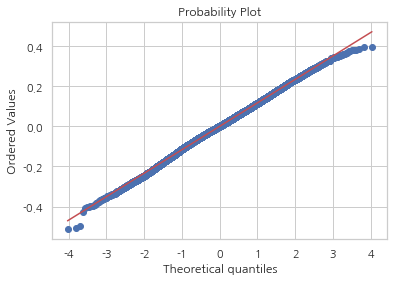

In [14]:
# outlier remove result 
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [15]:
test = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       : 40.757
P-value     :  0.000


# Partial Regression Plot
Let's visualize the influence of a single independent variable.

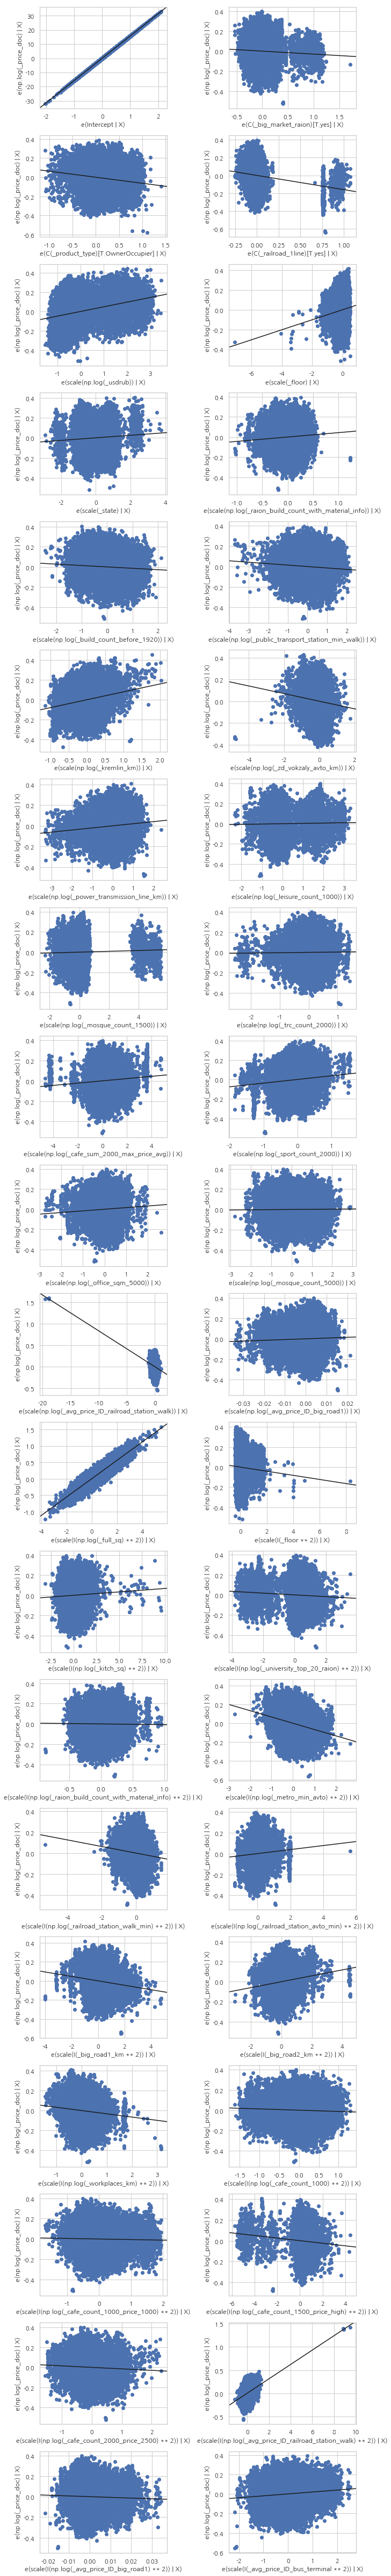

In [16]:
fig = plt.figure(figsize=(10,70))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

# 6. Cross Validation

In [17]:
dm = dmatrix(" + ".join(sms_vars) + ' + np.log(_price_doc)', df_train_macro_with_outliers, return_type="dataframe")
X = dm[dm.columns.drop(['np.log(_price_doc)'])]
y = dm['np.log(_price_doc)']
cv = cv = KFold(n_splits=1000, shuffle=True, random_state=0)
r2s = cross_val_score(SMWrapper(sm.OLS), X, y, scoring='r2', cv=cv)
r2s.mean()

0.38938622774797416

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  2.,  3.,  2.,  1.,  1.,  1.,  1.,
         1.,  2.,  1.,  5.,  4.,  1.,  5.,  8., 10.,  8.,  7.,  4., 11.,
        11., 16., 14., 12., 13., 16., 13., 13., 13., 18., 22., 20., 24.,
        27., 21., 29., 28., 33., 28., 20., 38., 38., 25., 32., 31., 26.,
        26., 27., 26., 19., 20., 26., 29., 15., 25., 11., 15., 15.,  8.,
        20.,  9., 11.,  6.,  6.,  5.,  8.,  4.,  3.]),
 array([-0.74079404, -0.72497596, -0.70915788, -0.6933398 , -0.67752172,
        -0.66170364, -0.64588556, -0.63006748, -0.6142494 , -0.59843132,
        -0.58261324, -0.56679516, -0.55097708, -0.535159  , -0.51934092,
        -0.50352284, -0.48770476, -0.47188668, -0.4560686 , -0.44025052,
        -0.42443244, -0.40861437, -0.39279629, -0.37697821, -0.36116013,
        -0.34534205, -0.32952397, -0.31370589, -0.29788781, -0.282069

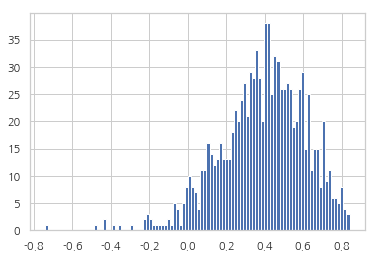

In [18]:
plt.hist(r2s, bins=100)

In [19]:
y_pred = np.exp(result.predict(df_test_macro))
y_pred = y_pred.to_frame('price_doc')
y_pred.to_csv('../submissions/stats_models_{}.csv'.format(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')), header=True, index=True)

## Score

RMSLE : 0.39329

In [21]:
for col in df_train_macro_with_outliers.columns:
    df_train_macro_with_outliers.rename(columns={col:col[1:]}, inplace=True)
for col in df_train_macro.columns:
    df_train_macro.rename(columns={col:col[1:]}, inplace=True)
df_train_macro_with_outliers.to_csv('../input/train_macro_with_outliers.csv', header=True, index=True)
df_train_macro.to_csv('../input/train_macro_without_outliers.csv', header=True, index=True)